Сразу установим все, что нужно

In [1]:
!pip install catboost xgboost scikit-learn matplotlib seaborn joblib pandas numpy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.5 MB/s eta 0:00:00


In [2]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО 4.xlsx")
cols_to_drop= ['IC50, mM', 'SI', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
display(df.head())

,"CC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,175.482382,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,5.402819,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,161.142320,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
3,107.855654,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,0,4,0
4,139.270991,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0


Топ-10 наиболее важных дескрипторов для CC50:
LabuteASA           0.057715<br>
BCUT2D_MWLOW        0.042473<br>
Chi1                0.038697<br>
Kappa3              0.038478<br>
Kappa2              0.037475<br>
FpDensityMorgan1    0.034774<br>
BCUT2D_MRLOW        0.030914<br>
MolMR               0.026832<br>
VSA_EState7         0.023108<br>
dtype: float64

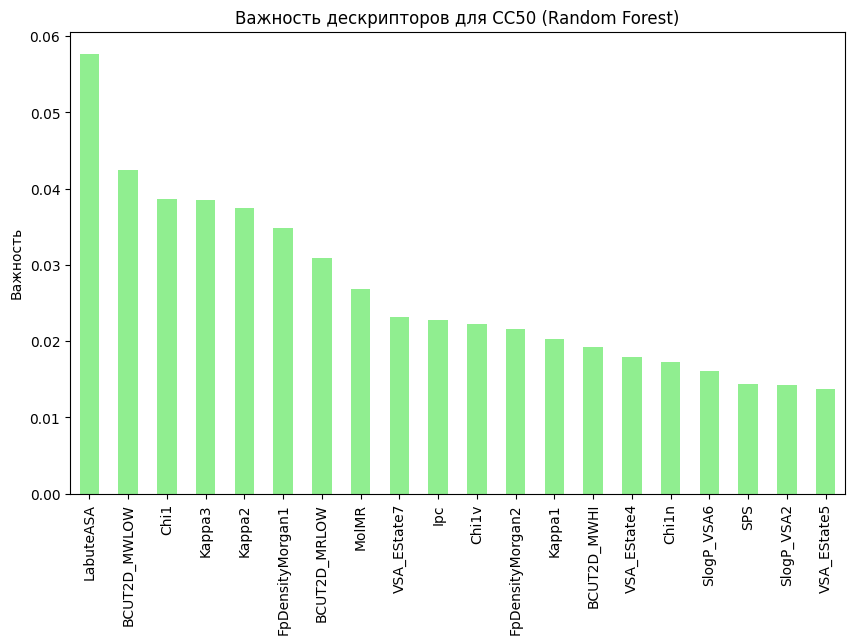

Сперва настроим стиль для дальнейшей визуализации

In [3]:
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('ggplot')

sns.set_theme(style="whitegrid")
sns.set_palette("husl")


In [4]:
# Целевая переменная
target = 'CC50, mM'

# Исключаем ненужные столбцы
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI']
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

# Добавление новых признаков
if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

# Полиномиальные признаки
polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered), columns=df_engineered.columns)


In [5]:
# Модели для перебора
regression_models = {
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
    'Stacking': StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', XGBRegressor(random_state=42))
        ],
        final_estimator=LinearRegression()
    )
}

def evaluate_model(name, model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2}, model

# Оценка моделей
results = []
best_model = None
best_r2 = -np.inf

for name, model in regression_models.items():
    metrics, trained_model = evaluate_model(name, model, df_engineered, y)
    results.append(metrics)

    if metrics['R2'] > best_r2:
        best_r2 = metrics['R2']
        best_model = trained_model


Создадим красивую таблицу для отображения результатов

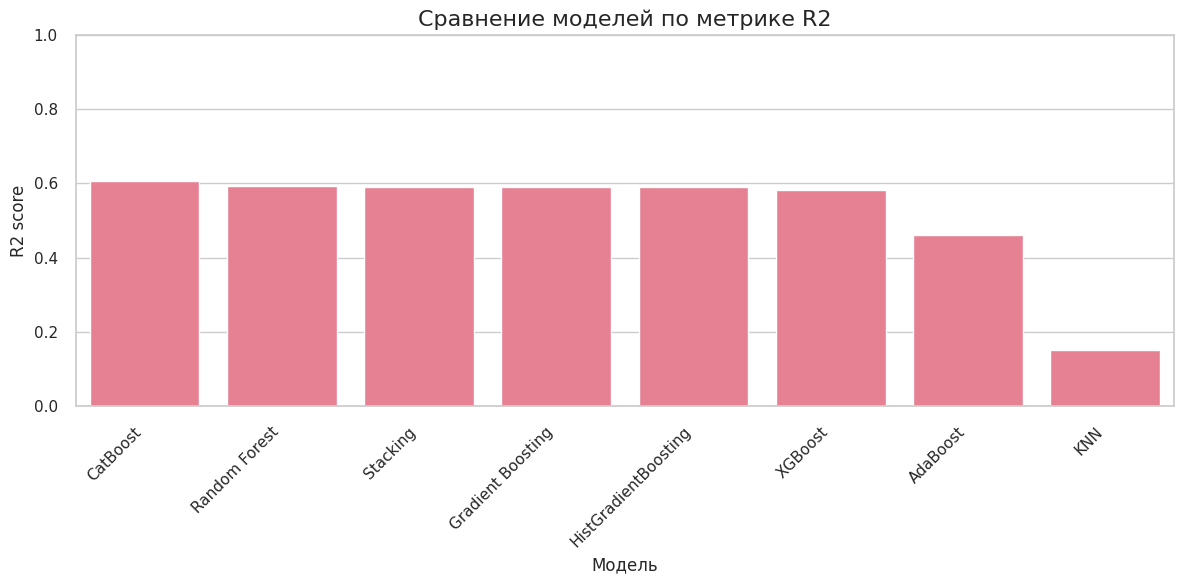


Результаты моделей (таргет: CC50, mM):


,Model,MSE,RMSE,R2
6,CatBoost,"203,547.986",451.163,0.607
1,Random Forest,"211,602.706",460.003,0.592
7,Stacking,"212,600.748",461.086,0.590
2,Gradient Boosting,"212,740.976",461.239,0.590
3,HistGradientBoosting,"213,087.389",461.614,0.589
5,XGBoost,"216,411.994",465.201,0.583
4,AdaBoost,"280,075.806",529.222,0.460
0,KNN,"439,932.963",663.274,0.151


In [6]:
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False).round(3)

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R2', data=results_df.sort_values('R2', ascending=False))
plt.title('Сравнение моделей по метрике R2', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('R2 score')
plt.xlabel('Модель')
plt.tight_layout()
plt.show()

def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [('background-color', '#40466e'),
                                    ('color', 'white'),
                                    ('font-weight', 'bold'),
                                    ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f5f5f5')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'white')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]}
    ]

    return (df.style
              .set_table_styles(styles)
              .format({'MSE': '{:,.3f}',
                      'RMSE': '{:,.3f}',
                      'R2': '{:,.3f}'})
              .highlight_max(subset=['R2'], color='#90EE90')
              .highlight_min(subset=['R2'], color='#FFCCCB'))

print("\nРезультаты моделей (таргет: CC50, mM):")
display(display_beautiful_table(results_df))



In [8]:
# Сохранение лучшей модели
if best_model is not None:
    best_model_name = results_df.iloc[0]['Model']
    filename = f'best_model_for_CC_50_{best_model_name}.pkl'
    joblib.dump(best_model, filename)
    print(f"\nЛучшая модель '{best_model_name}' сохранена в файл: {filename}")


Лучшая модель 'CatBoost' сохранена в файл: best_model_for_CC_50_CatBoost.pkl
